In [55]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [56]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from rag.pdf import PDFRetrievalChain
from langchain_teddynote.tools.tavily import TavilySearch

from typing import List, Literal
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_core.documents import Document

In [57]:
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

### PDF 기반 문서 검색기 (Retrieval chain) 생성

In [58]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### PDF 기반 문서 검색기 (Retrieval chain) : 사용자 질문에 대한 PDF 문서를 검색

In [59]:
# 문서 검색 노드
def retrieve(state: GraphState):
    print('\n==========================================================================================')
    print('===== [RETRIEVE] retieve() 노드 실행 =====')

    # 사용자 질문
    question = state['question']        

    # 문서 검색 (pdf_retriever 에 사용자 입력을 인자로 넣어서 문서를 검색)
    documents = pdf_retriever.invoke(question)
    
    print(f'문서 검색 결과: ')
    print(documents)
    print('==========================================================================================\n')
    
    return {'documents': documents}

### 답변 생성을 위한 RAG 체인

In [60]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain import hub

# prompt = hub.pull("teddynote/rag-prompt")

template = """You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If you can't find the source of the answer, you should answer that you don't know.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

# Your final ANSWER to the user's QUESTION:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

output_parser = StrOutputParser()

# RAG 체인 생성 (pdf_retriever 문서 검색기를 사용해서 얻은 문서와 사용자 질문을 넣어서 결과)
rag_chain = prompt | llm | output_parser

### 답변 생성을 위한 RAG 체인을 실행하여 사용자 질문에 대한 답변을 생성하는 노드

In [61]:
# 답변 생성 노드
def generate(state: GraphState):
    print('\n==========================================================================================')
    print('===== [GENERATE] generate() 함수 =====')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # RAG 실행 결과
    generation = rag_chain.invoke({'context': documents , 'question': 'question'})

    print(f'사용자 질문: {question}')
    print(f'문서 검색 결과:')
    print(documents)
    print()
    print(f'rag 실행 결과:')
    print(generation)
    print()
    print('==========================================================================================\n')    

    return {'generation': generation}

### 문서 검색 평가기 (Retrieval Grader)

In [62]:
class GradeDocuments(BaseModel):        # 문서 평가를 위한 데이터 모델
    """Binary score for relevance check on retrieved documents."""

    # 사용자 질문에 대한 pdf 문서 검색 결과를 평가하는 문서 검색 평가기(retrieval_grader)를 사용해서 
    # 사용자 질문과 검색 결과문서가 관련성이 있는지 본다

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 메시지
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 프롬프트 템플릿
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기
retrieval_grader = grade_prompt | structured_llm_grader

### 사용자 질문에 대한 pdf 문서 검색 결과의 관련성을 평가하는 문서 검색 평가기(retrieval_grader) 노드

In [63]:
# 문서 검색 결과와 질문 관련성 평가 노드
def grade_documents(state: GraphState):
    print('\n==========================================================================================')
    print('===== [CHECK DOCUMENT RELEVANCE TO QUESTION] grade_documents() 함수 =====')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # 문서 검색 평가기를 통과한 문서들만 필터링
    filtered_docs = []

    for doc in documents:
        score = retrieval_grader.invoke({'question': question, 'document': doc.page_content})

        grade = score.binary_score

        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")     
            filtered_docs.append(doc)                   
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---") 
            continue     

    print('==========================================================================================\n')
    return {'documents': filtered_docs}

### 쿼리 재작성 (Query Rewriter)

In [64]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# Query Rewriter 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_writer_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', 'Here is the initial question: \n\n {question} \n Formulate an improved question')
    ]
)

# Query Rewriter 생성
question_rewriter = re_writer_prompt | llm | StrOutputParser()

### Query Rewrite 노드

In [65]:
# Query Rewrite 노드
def transform_query(state: GraphState):
    print('\n==========================================================================================')
    print('===== [TRANSFORM QUERY] transform_query() 함수 =====')

    # 사용자 질문
    question = state['question']

    # 문서 검색 결과
    documents = state['documents']

    
    # 쿼리 재작성
    better_question = question_rewriter.invoke({'question': question})
    print(f"better_question: {better_question}")
    print('==========================================================================================\n')

    return {'question': better_question}

### 웹 검색 도구

In [66]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=2)

### 웹 검색 노드

In [67]:
# 웹 검색 노드
def web_search(state):
    print('\n==========================================================================================')
    print('===== [WEB SEARCH] web_search() 함수 =====')

    # 사용자 질문
    question = state['question']
    
    print(f"question: ")
    print(question)
    print()

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})

    print('web_results: ')
    print(web_results)
    print()

    web_results_docs = []
    
    for result in web_results:
        doc = Document(
            page_content=result["content"],
            metadata={"source": result["url"]}
        )
        web_results_docs.append(doc)

    print(web_results_docs)
    print('==========================================================================================\n')

    return {"documents": web_results_docs}

### 질문 라우팅 노드

In [68]:
class RouteQuery(BaseModel):    
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# 구조화된 출력을 결과로 가젼온다 (vectorstore, web_search)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to DEC 2023 AI Brief Report(SPRI) with Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# 프롬프트
route_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', '{question}')
    ]
)

question_router = route_prompt | structured_llm_router

### 질문 라우팅 노드

In [69]:
# 질문 라우팅 노드
def route_question(state: GraphState):
    print('\n==========================================================================================')
    print('===== [ROUTE QUESTION] route_question() 함수 =====')

    # 사용자 질문
    question = state['question']

    # 질문 라우팅
    source = question_router.invoke({'question': question})

    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        print('==========================================================================================\n')
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        print('==========================================================================================\n')
        return "vectorstore"

### 문서 관련성 평가 노드

In [70]:
# 문서 관련성 평가 노드
def decide_to_generate(state: GraphState):
    print('\n==========================================================================================')
    print('===== [DECISION TO GENERATE] decide_to_generate() 함수 =====')

    # 문서 검색 결과 가져오기
    filtered_documents = state['documents']

    if not filtered_documents:                              # 문서가 없는 경우 (모든 문서가 관련성 없는 문서)
        print(f'===== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] =====')
        print('==========================================================================================\n')
        return "transform_query"        
    else:                                                   # 관련성 있는 문서가 있는 경우
        print(f"===== [DECISION: GENERATE] =====")
        print('==========================================================================================\n')
        return "generate"

# 답변에 대한 Hallucination checker 추가

In [71]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# system
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
) 

# hallucination 평가기 생성
hallucination_grader = hallucination_prompt | structured_hallucination_grader

In [72]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# system
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 템플릿
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

### hallucination_check

In [73]:
# Hallucination 평가 노드
def hallucination_check(state: GraphState):
    print('\n==========================================================================================')
    print('===== [CHECK hallucination] hallucination_check() 함수 =====')

    # 사용자 질문
    qestion = state['question']

    # 문서 검색 결과
    documents = state['documents']

    # 생성된 답변
    generation = state['generation']

    # 평가
    score = hallucination_grader.invoke({'documents': documents, 'generation': generation})
    grade = score.binary_score

    print(f"===== [평가 결과] =====")
    print(grade)

    if grade == 'yes':     # hallucination 없음
        print("===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====")
        print("no hallucination")

        # 답변에 대한 관련성 평가
        print("===== [GRADE GENERATED ANSWER vs QUESTION] =====")

        score = answer_grader.invoke({'question': state['question'], 'generation': generation})
        grade = score.binary_score

        if grade == 'yes':          # 관련성 있는 답변
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            print("relevant")
            print('==========================================================================================\n')
            return "relevant"
        else:                       # 관련성 없는 답변
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            print("not relevant")
            print('==========================================================================================\n')
            return "not relevant"

    else:                   # hallucination 있음
        print("===== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] =====")
        print("hallucination")
        print('==========================================================================================\n')
        return "hallucination"

# 테스트

In [74]:
state = GraphState(
    question='대구 중앙떡볶이',
    generation = '', 
    documents = []
)

state

{'question': '대구 중앙떡볶이', 'generation': '', 'documents': []}

In [75]:
route_question(state)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO WEB SEARCH] ====



'web_search'

In [76]:
web_search(state)


===== [WEB SEARCH] web_search() 함수 =====
question: 
대구 중앙떡볶이

web_results: 
[{'title': '대구 동성로 학창시절부터 있는 쌀떡 납작만두가 맛있는 웨이팅 긴 분식 맛집 "중앙떡볶이" 내돈내먹 후기', 'url': 'https://blog.naver.com/PostView.nhn?blogId=ds7646211&logNo=223771531872', 'content': '11:54URL 복사이웃추가본문 기타 기능공유하기신고하기주소:대구 중구 동성로2길 81 중앙떡볶이T: 053-424-7692영업시간: 11:30 - 18:00 (매주 일요일 휴무)포장, 배달동성로 중앙떡볶이(@psk1670) • Instagram 사진 및 동영상팔로워 385명, 팔로잉 81명, 게시물 92개 - 동성로 중앙떡볶이(@psk1670)님의 Instagram 사진 및 동영상 보기www.instagram.com중앙떡볶이대구광역시 중구 동성로2길 81 중앙떡볶이학창시절때부터 자리를 잡고 있는 중앙떡볶이 2년만에 먹고 싶어서 기다린 웨이팅 맛집이에요 기다린 끝에 먹는 내돈내먹 분식 맛집이양중앙떡볶이는 제가 태어나기전부터 생긴 분식 맛집이랍니다 30년동안 한자리를 지켜온 맛집으로 믿고 먹는 맛집!228 기념공원 맞은편에 위치한 중앙 떡볶이 가끔 포장해서 집에 들고가고 출출할 때 맛있게 먹는 맛집이자 또간집이에요중앙떡볶이 사람 미쳤어요... 너무 좋고 밀떡이 아닌 쌀떡으로 요즘 물가 비싼데 쌀떡을 쓰셔서 너무 좋고 쫄깃한 식감과중앙떡볶이만의 매콤 달큰한 소스를 맛볼 수 있어서 너무 좋은 로컬 맛집이양 떡은 방앗간에서 바로 갓 나온 느낌이라 너무 좋았어요두툼한 오뎅스여기 만두가 여태껏 먹는 만두중에 만두피가 제일 얇으면서 쫄깃쫄깃하고 바삭하게 굽지 않았는데 이렇게 촉촉하고 부드러울수가....만두에 떡볶이 소스 무조건 찍먹해서 드셔주세요...여기 만두 대체 뭘쓰는걸까......', 'score': 0.8783249, 'raw_conten

{'documents': [Document(metadata={'source': 'https://blog.naver.com/PostView.nhn?blogId=ds7646211&logNo=223771531872'}, page_content='11:54URL 복사이웃추가본문 기타 기능공유하기신고하기주소:대구 중구 동성로2길 81 중앙떡볶이T: 053-424-7692영업시간: 11:30 - 18:00 (매주 일요일 휴무)포장, 배달동성로 중앙떡볶이(@psk1670) • Instagram 사진 및 동영상팔로워 385명, 팔로잉 81명, 게시물 92개 - 동성로 중앙떡볶이(@psk1670)님의 Instagram 사진 및 동영상 보기www.instagram.com중앙떡볶이대구광역시 중구 동성로2길 81 중앙떡볶이학창시절때부터 자리를 잡고 있는 중앙떡볶이 2년만에 먹고 싶어서 기다린 웨이팅 맛집이에요 기다린 끝에 먹는 내돈내먹 분식 맛집이양중앙떡볶이는 제가 태어나기전부터 생긴 분식 맛집이랍니다 30년동안 한자리를 지켜온 맛집으로 믿고 먹는 맛집!228 기념공원 맞은편에 위치한 중앙 떡볶이 가끔 포장해서 집에 들고가고 출출할 때 맛있게 먹는 맛집이자 또간집이에요중앙떡볶이 사람 미쳤어요... 너무 좋고 밀떡이 아닌 쌀떡으로 요즘 물가 비싼데 쌀떡을 쓰셔서 너무 좋고 쫄깃한 식감과중앙떡볶이만의 매콤 달큰한 소스를 맛볼 수 있어서 너무 좋은 로컬 맛집이양 떡은 방앗간에서 바로 갓 나온 느낌이라 너무 좋았어요두툼한 오뎅스여기 만두가 여태껏 먹는 만두중에 만두피가 제일 얇으면서 쫄깃쫄깃하고 바삭하게 굽지 않았는데 이렇게 촉촉하고 부드러울수가....만두에 떡볶이 소스 무조건 찍먹해서 드셔주세요...여기 만두 대체 뭘쓰는걸까......'),
  Document(metadata={'source': 'https://m.blog.naver.com/ryu8145/223424913321'}, page_content='대구 맛집 백종원 3대 천왕 :: 중앙떡볶이 솔직 후기 : 네이버 블로그 본문 

In [77]:
state = GraphState(
    question='삼성전자가 만든 생성형 AI 이름은?',
    generation = '', 
    documents = []
)

state

{'question': '삼성전자가 만든 생성형 AI 이름은?', 'generation': '', 'documents': []}

In [78]:
route_question(state)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO VECTORSTORE] ====



'vectorstore'

In [79]:
answer = retrieve(state)                        # 사용자 질문에 대해서 관련 문서를 검색한다.
state['documents'] = answer['documents']


===== [RETRIEVE] retieve() 노드 실행 =====
문서 검색 결과: 
[Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', '

In [80]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [81]:
state['documents'] = grade_documents(state)['documents']


===== [CHECK DOCUMENT RELEVANCE TO QUESTION] grade_documents() 함수 =====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---



In [82]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [83]:
# state['generation'] = generate(state)['generation']
# 문서 검색 결과를 평가하는 평가기(retrieval_grader)를 사용해서 사용자 질문과 검색 결과문서가 관련성이 있는지 평가한다.
# retrieval_grader.invoke({'question': state['question'], 'document': state['documents']})

In [84]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [85]:
state['documents'] = grade_documents(state)['documents']


===== [CHECK DOCUMENT RELEVANCE TO QUESTION] grade_documents() 함수 =====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---



In [86]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [87]:
state['generation'] = generate(state)['generation']


===== [GENERATE] generate() 함수 =====
사용자 질문: 삼성전자가 만든 생성형 AI 이름은?
문서 검색 결과:
[Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer':

In [88]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '삼성전자가 공개한 생성 AI 모델 ‘삼성 가우스’는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동 가능하여 사용자 정보 유출 위험이 없다. 이 모델은 2023년 11월 8일 ‘삼성 AI 포럼 2023’에서 처음 소개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)',
 'documents': [Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadat

In [89]:
hallucination_check(state)


===== [CHECK hallucination] hallucination_check() 함수 =====
===== [평가 결과] =====
yes
===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====
no hallucination
===== [GRADE GENERATED ANSWER vs QUESTION] =====
==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====
relevant



'relevant'

In [90]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

In [91]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [92]:
######### 2. 노드 정의  #########

workflow.add_node('web_search', web_search)                 # 웹 검색  
workflow.add_node('retrieve', retrieve)                     # 문서 검색 노드
workflow.add_node('grade_documents', grade_documents)       # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
workflow.add_node('generate', generate)                     # 사용자 질문과 문서 검색결과를 가지고 답변 생성하는 노드
workflow.add_node('transform_query', transform_query)       # 사용자 질문(쿼리)를 재작성하는 노드

In [93]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_conditional_edges(
    START, 
    route_question,                     # 질문 라우팅 노드  
    {
        'web_search': 'web_search',     # 웹 검색으로 라우팅
        'vectorstore': 'retrieve'       # retrieve (PDF 문서 검색)로 라우팅
    }
)

In [94]:
workflow.add_edge('web_search', 'generate')         # 웹 검색하고 답변 생성
workflow.add_edge('retrieve', 'grade_documents')    # retrieve 노드에서 PDF 문서 검색실행 하고 결과를 문서 검색 평가기로 가서 평가

In [95]:
workflow.add_conditional_edges(
    'grade_documents',                              # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
    decide_to_generate,                             # 문서 관련성 평가
    {
        'transform_query': 'transform_query',       # 사용자 입력 다시 작성 필요
        'generate': 'generate'                      # 답변 생성
    }
)

In [96]:
workflow.add_edge('transform_query', 'retrieve')    # 쿼리 다시 작성한 뒤 문서 검색

In [97]:
workflow.add_conditional_edges(
    'generate',
    hallucination_check,
    {
        'hallucination': 'generate',                # Hallucination 발생 시 재생성
        'relevant': END,                            # 답변 관련성 통과     
        'not relevant': 'transform_query'           # 딥변 관련성 통과 못하는 경우. 쿼리 다시 작성
    }
)

In [98]:
######### 4. 체크 포인터 설정  #########

memory = MemorySaver()

In [99]:
######### 5. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

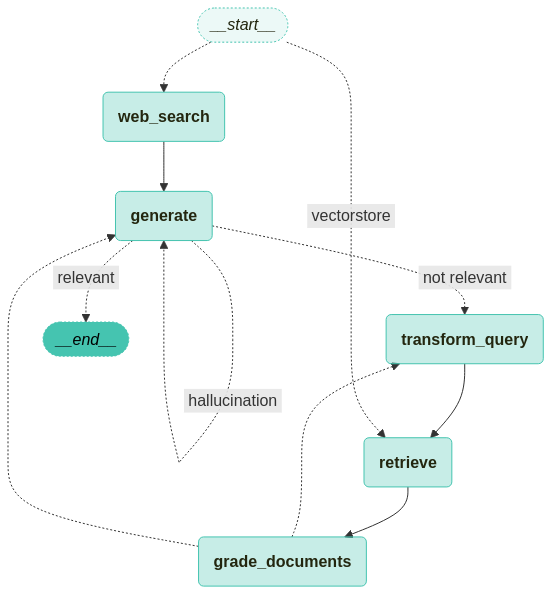

In [100]:
visualize_graph(app)

In [101]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

In [102]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 개발한 생성형 AI 이름은?')

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO VECTORSTORE] ====


===== [RETRIEVE] retieve() 노드 실행 =====
문서 검색 결과: 
[Document(id='be5349d9-7d40-4c8f-8147-41c7d04c1f22', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원'), Document(id='08fb148b-9396-4ae6-866f-01e236fc1eb4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'pa

In [103]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 동성로')

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO WEB SEARCH] ====


===== [WEB SEARCH] web_search() 함수 =====
question: 
대구 동성로

web_results: 
[{'title': '동성로 - 나무위키', 'url': 'https://namu.wiki/w/동성로', 'content': '도로 동성로는 말 그대로 대구읍성의 동쪽 성벽을 허물고 낸 0.92km의 길을 말한다. 동성로 관광안내소 [4]-동성로 28 아트스퀘어-CGV 대구한일-대구역 구간까지로, 지금도 상권 동성로의 메인스트리트 중심가다. 상권 동성로는 남쪽으로 반월당역과 달구벌대로, 서쪽으로 중앙대로 혹은 종로 주변 [5', 'score': 0.8914433, 'raw_content': None}, {'title': '동성로 (대구) - 위키백과, 우리 모두의 백과사전', 'url': 'https://ko.wikipedia.org/wiki/동성로_(대구)', 'content': '과거 대구읍성의 성곽이 있었으나, 1907년에 일본인 상권 확보의 목적으로 친일 관료에 의해 성곽이 사라진 자리가 도로가 되었고, 그 성곽의 동쪽에 해당하는 터는 현재의 \'동성로\'가 조성되었다.. 동성로는 1914년 "동성정"이라 하였다가 1946년에 "동성로"로 바뀌었다. [3]', 'score': 0.8585411, 'raw_content': "목차\n\n동성로 (대구)\n\n\n\n동성로(東城路)는 대구광역시 중구의 법정동이자, 동성로 관광안내소에서 대구역네거리에 이르는 구간에 조성된 대구광역시 최대 번화가의 명칭이다. 단핵 도심 체제의 대구 사람들에게는 시내(다운타운)로 통하기도 한다.\n\n개요\n\n행정구역 상으로는 법정동 동성로1~3가에 해당하며, 행정동명으로는 동성로1~2가가 성내1동, 동성로3가는 성내2동에 해당한다.\n\n동성로는 백화점, 쇼핑센터, 패션타운, 호텔,